# Run FinalTestV2 and Visualise Results
This notebook:

2. Loads metrics.csv
3. Plots loss, training accuracy, and validation accuracy vs epoch
4. Loads dead-neuron CSVs and displays a heatmap

In [18]:
import os
import sys

PROJECT_ROOT = os.path.abspath(".") 
sys.path.insert(0, PROJECT_ROOT)


## RUN FINALTESTV2.PY

RUN: T1G7_FINAL_relu_momentum_dropout_decay


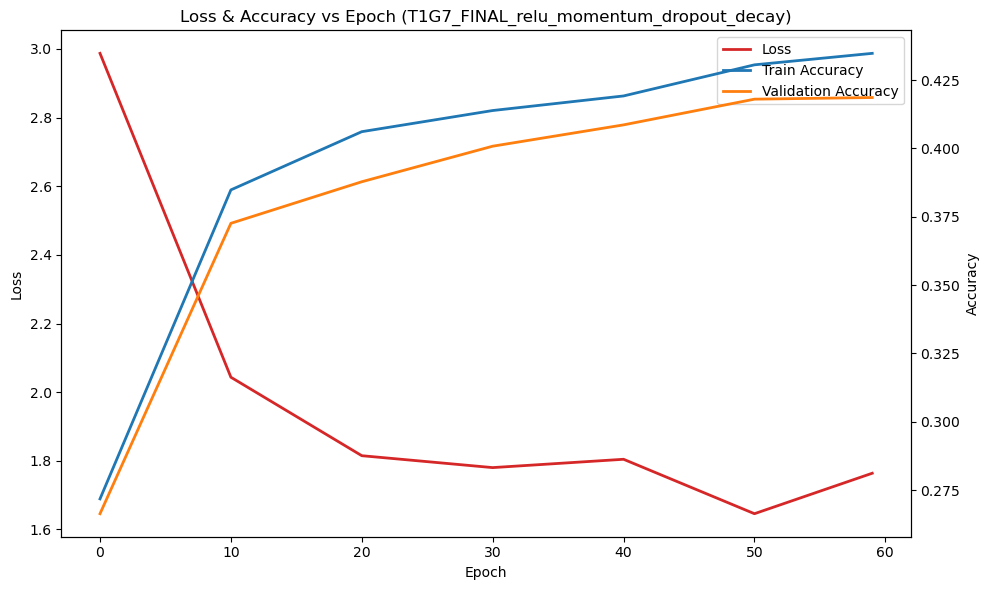

RUN: T1G7_M1_relu_sgd_decay_l2


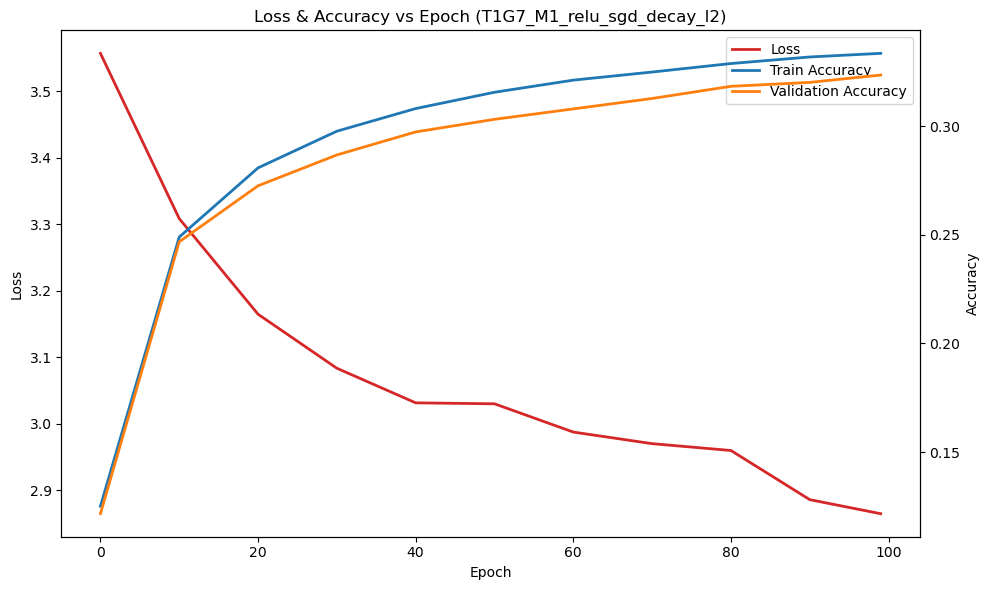

RUN: T1G7_M2_relu_momentum_l2


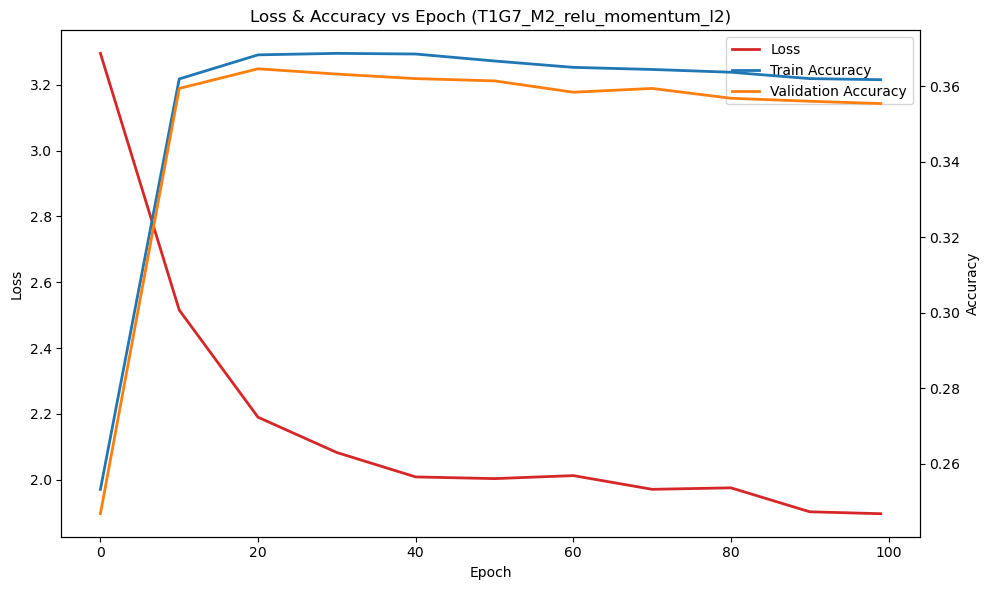

RUN: T1G7_M3_relu_adam_dropout_l2


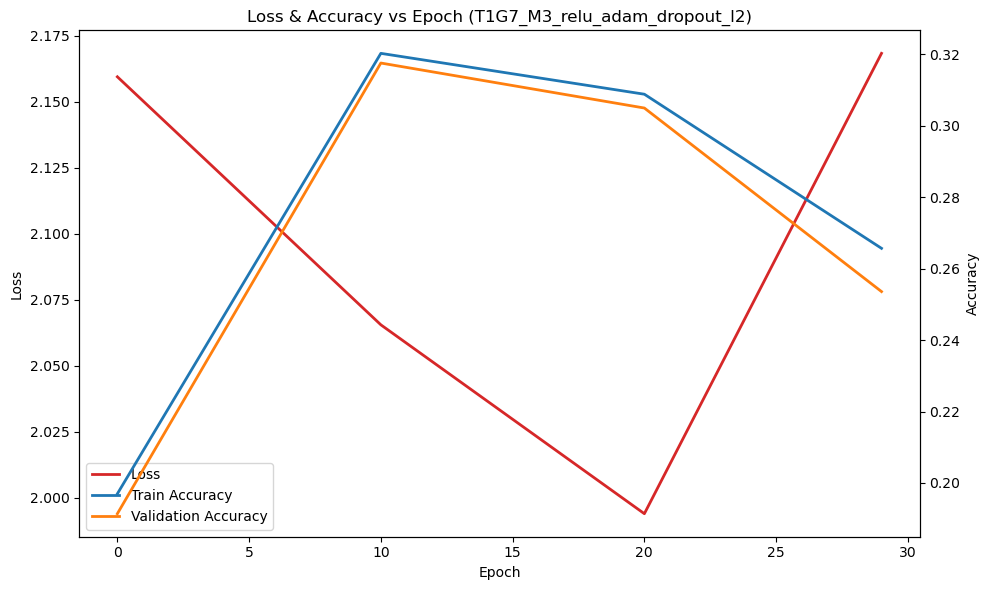

RUN: T1b_relu_sgd_bs256_epochs150


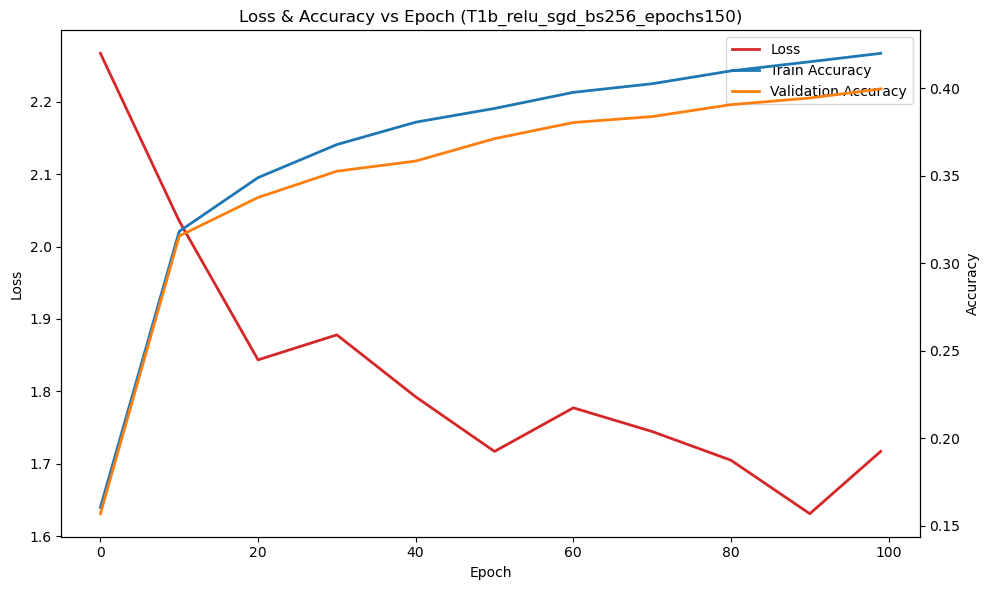

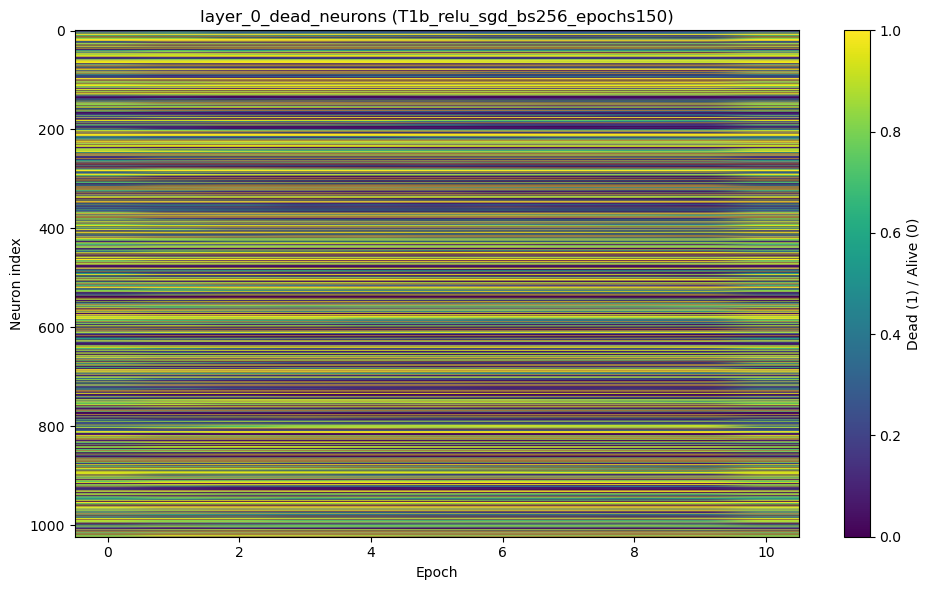

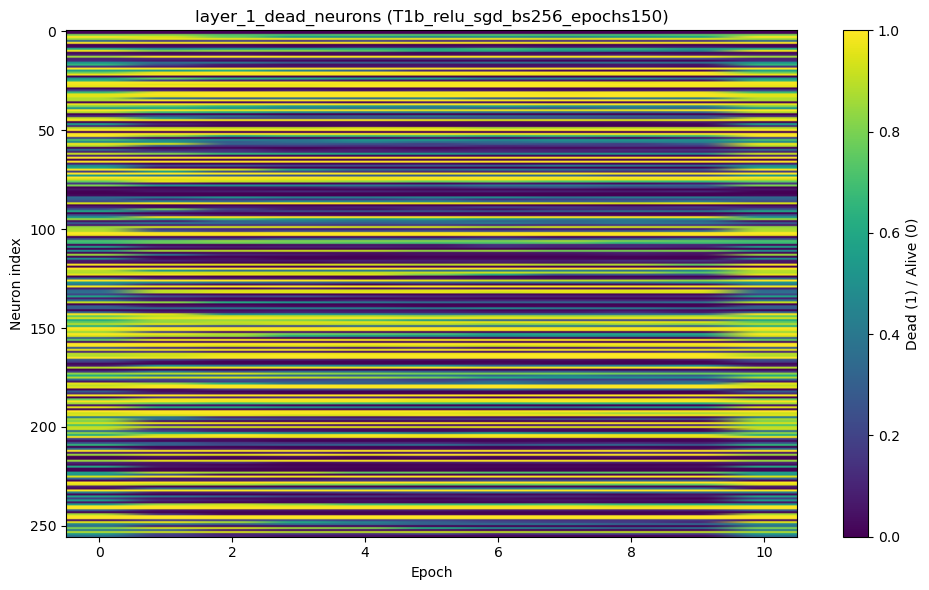

RUN: T1b_sigmoid_sgd_bs256_epochs150


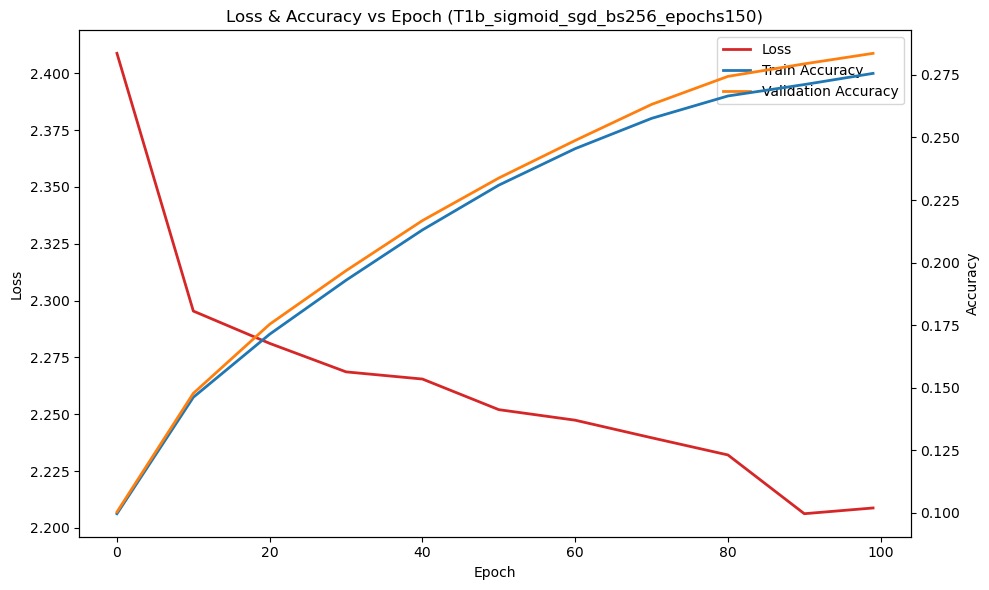

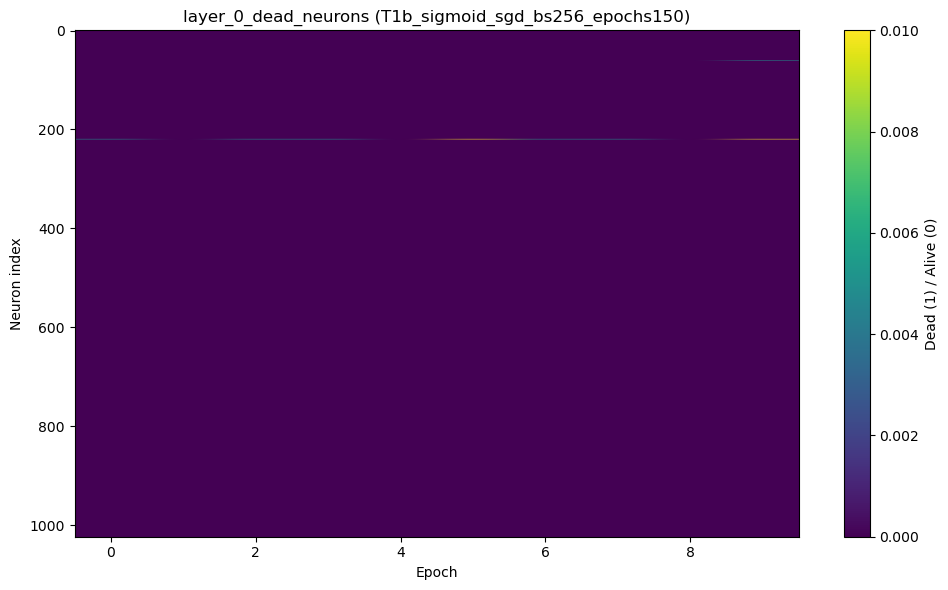

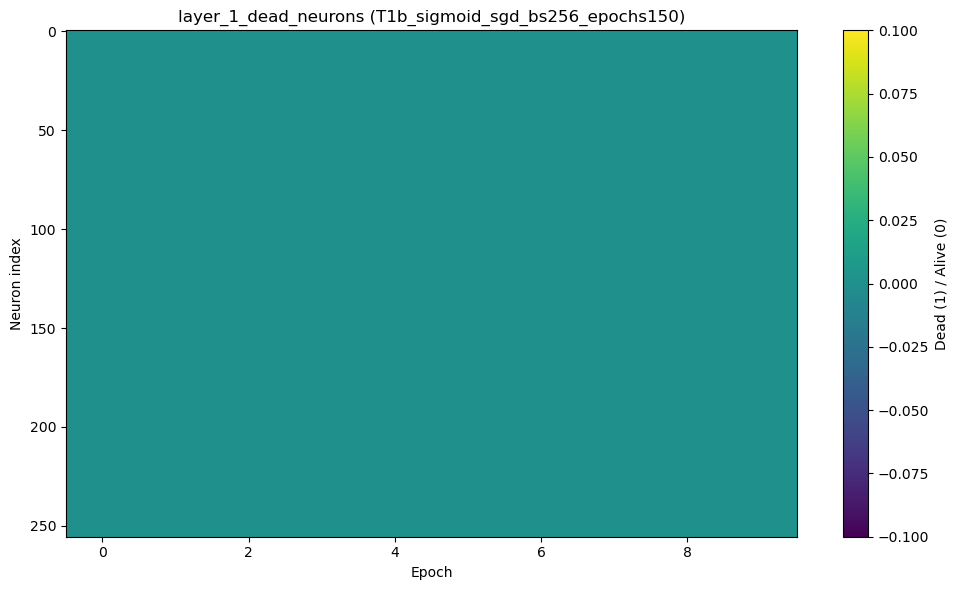

RUN: T1d_relu_sgd_dropout0.5


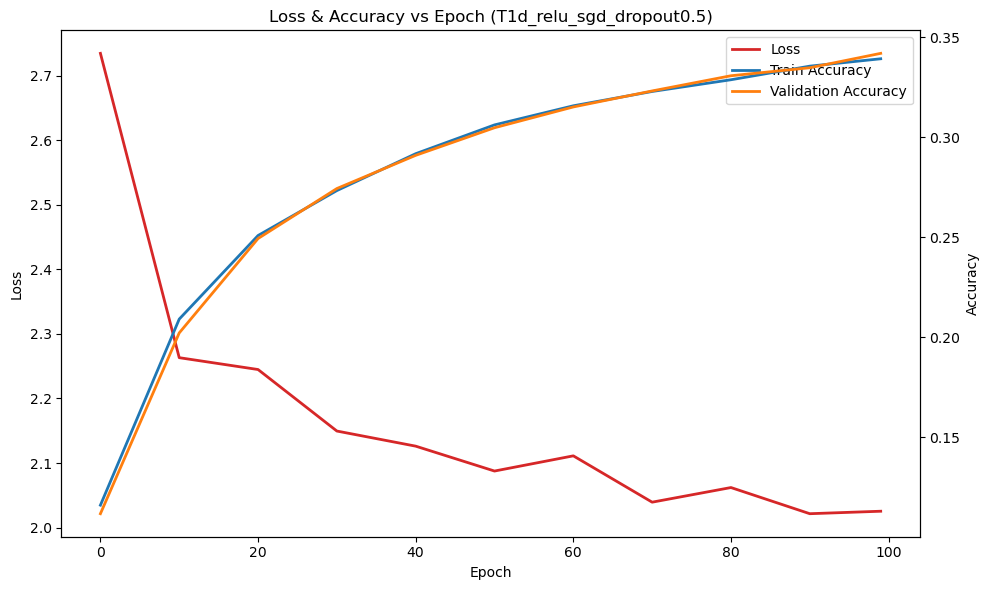

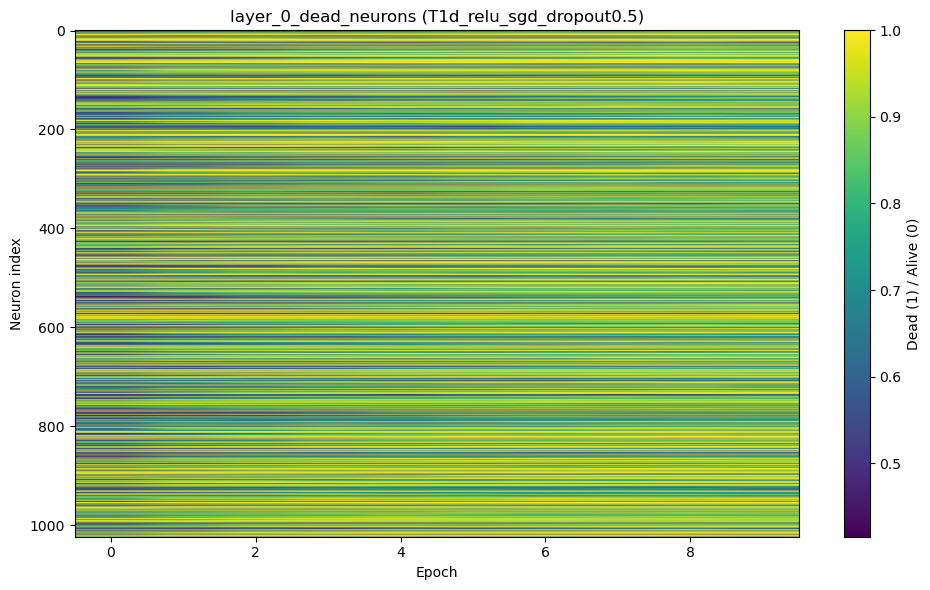

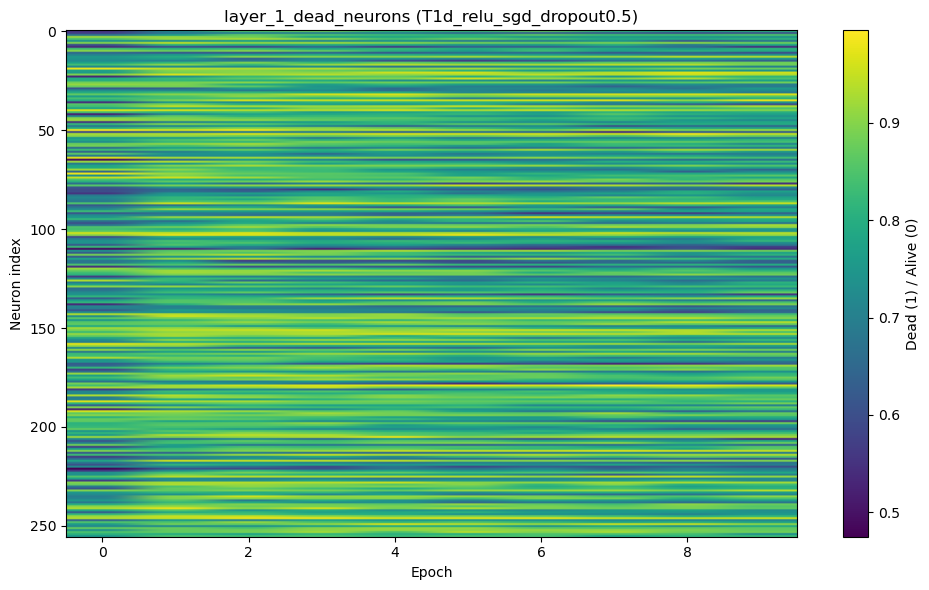

RUN: T1d_relu_sgd_no_dropout


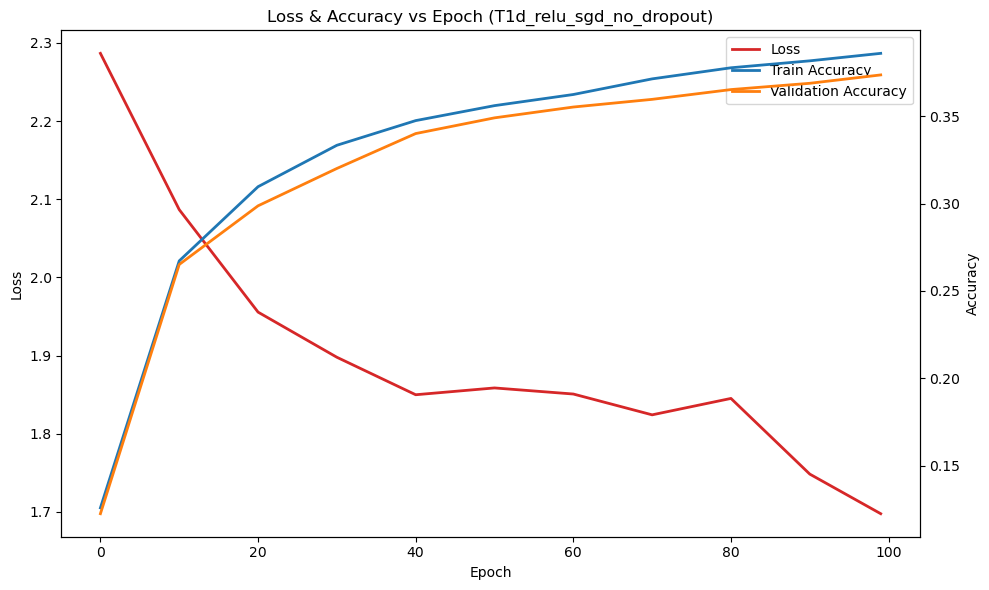

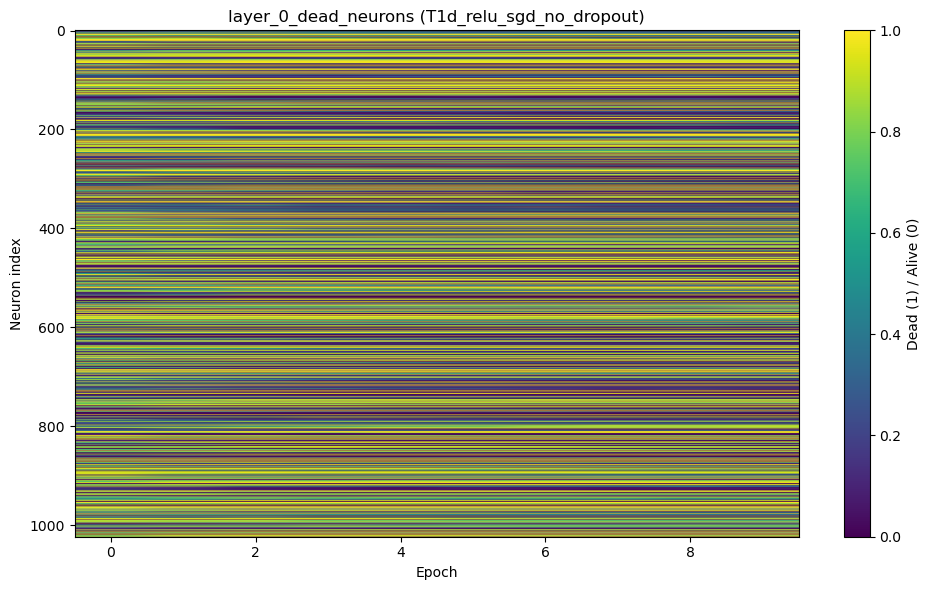

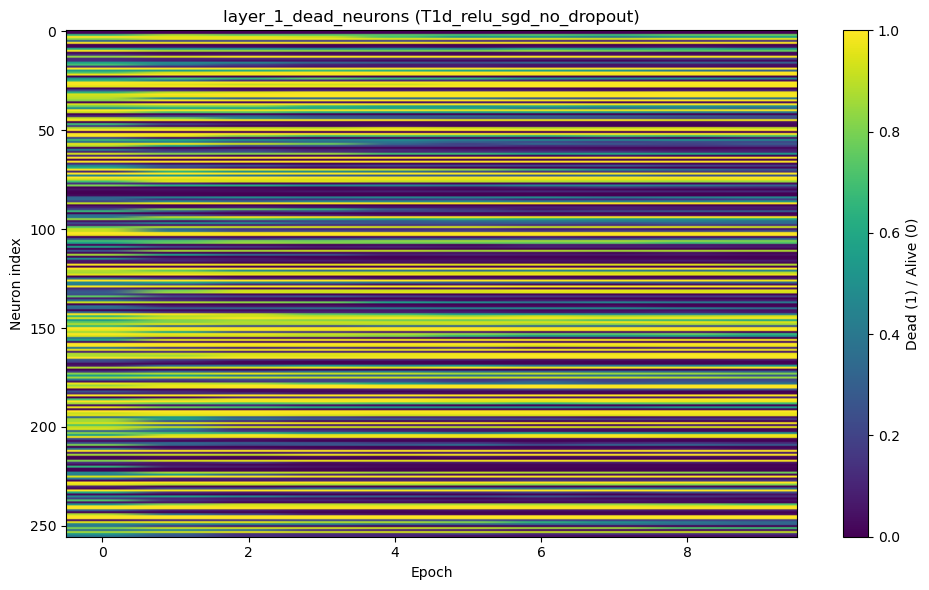

RUN: T1e_param_deep_relu


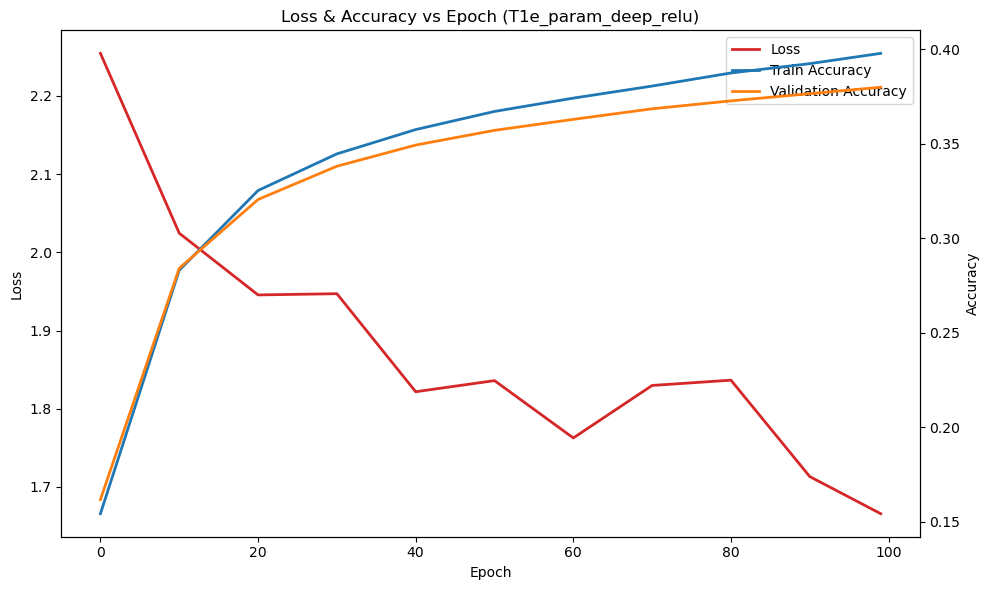

RUN: T1e_param_shallow_relu


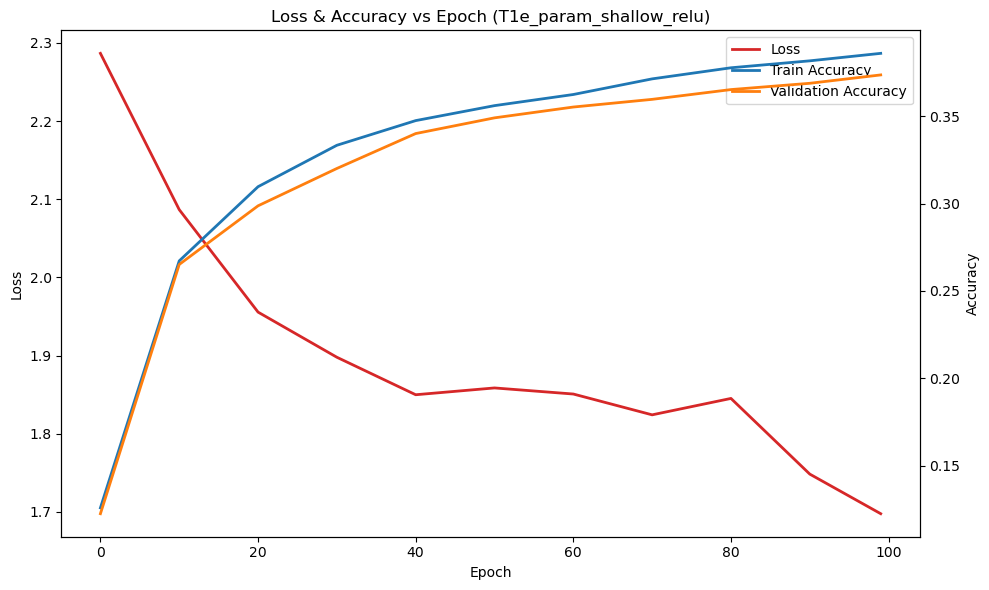

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

LOGS_DIR = "logs"

for run_name in sorted(os.listdir(LOGS_DIR)):
    run_path = os.path.join(LOGS_DIR, run_name)
    if not os.path.isdir(run_path):
        continue

    print("=" * 60)
    print(f"RUN: {run_name}")
    print("=" * 60)

    # ---- Metrics (combined plot with two Y axes) ----
    metrics_path = os.path.join(run_path, "metrics.csv")
    if os.path.exists(metrics_path):
        metrics = pd.read_csv(metrics_path)

        # 👇 High-resolution figure
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Loss on left Y-axis
        loss_line, = ax1.plot(
            metrics['epoch'],
            metrics['loss'],
            label='Loss',
            color='tab:red',
            linewidth=2
        )
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f"Loss & Accuracy vs Epoch ({run_name})")

        # Accuracy on right Y-axis
        ax2 = ax1.twinx()
        train_line, = ax2.plot(
            metrics['epoch'],
            metrics['train_accuracy'],
            label='Train Accuracy',
            linewidth=2
        )
        val_line, = ax2.plot(
            metrics['epoch'],
            metrics['validation_accuracy'],
            label='Validation Accuracy',
            linewidth=2
        )
        ax2.set_ylabel('Accuracy')

        # Combined legend
        lines = [loss_line, train_line, val_line]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best')

        plt.tight_layout()
        plt.show()
    else:
        print("No metrics.csv found")

    # ---- Dead neuron heatmaps ----
    for file in sorted(os.listdir(run_path)):
        if file.startswith("layer_") and file.endswith("_dead_neurons.csv"):
            layer_path = os.path.join(run_path, file)
            dead_df = pd.read_csv(layer_path)

            data = dead_df.drop(columns=['epoch']).to_numpy().T

            plt.figure(figsize=(10, 6), dpi=100)
            plt.imshow(data, aspect='auto')
            plt.colorbar(label='Dead (1) / Alive (0)')
            plt.xlabel('Epoch')
            plt.ylabel('Neuron index')
            plt.title(f"{file.replace('.csv','')} ({run_name})")
            plt.tight_layout()
            plt.show()
